In [1]:
#DIR = "/Users/matteofoglieni/Dropbox/GR_effects/Matteo_Output/fNL_effective_z115/";
DIR = "Effective_fNL_z115_files/";

ps_kwargs(twofast::Bool) = twofast ?
    Dict(:twofast=>true, :epl => true, :pr => false, 
          :N_left => 12, :N_right => 12,
          :p0_left => [-2.0, 1.0], :p0_right => [-2.0, 1.0],
          :int_s_min => 1e0, :int_s_max => 1200.0) :
    Dict(:twofast=>false, :pr=>true, :ν => 1.5, :n_extrap_low => 0,
     :n_extrap_high => 0, :n_pad => 500, :cut_first_n=>6);
tf = false;

## Basic Framework

In [2]:
PATH_TO_GAPSE = "../";

In [3]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [4]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, TwoFAST, ProgressMeter
using Printf, LaTeXStrings, Turing, StatsPlots, GridInterpolations, LegendrePolynomials
pyplot()

Plots.PyPlotBackend()

In [5]:
#z_min, z_max, θ_max = 0.05, 0.20, π / 2.0
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0

WFI_opts = Dict(
    :ss_start => 0.0, :ss_stop => 0.0, 
    :ss_step => 50, :llim => 0.0, :rlim => Inf, 
    :rtol => 5e-2, :atol => 0.0, :N => 1000, #:pr => true,
)

FILE_F_MAP = PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt"
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt"
FILE_BACKGROUND = PATH_TO_GAPSE * "test/datatest/WideA_ZA_background.dat"

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.0,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    WFI_opts = WFI_opts,
);

In [6]:
#=
new_calc_μs = union([μ for μ in -1.0:0.01:(-0.9)], 
        [μ for μ in -0.9:0.05:0.9], 
        [μ for μ in 0.9:0.01:1.0]);
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"

GaPSE.print_map_IntegratedF(
    FILE_F_MAP, FILE_IF_MAP, 
    z_min, z_max, new_calc_μs, FILE_BACKGROUND;
    trap = true, WFI_opts...
)
=#

In [7]:
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../test/datatest/WideA_ZA_background.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Integrated F window function input file: "../data/IntF_pi2_z115.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.0 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - CosmoParams about the Integrated Window Function F: 
#	 ss_step = 50 	 N = 1000 	 rtol = 0.05

## Transfer Function

In [8]:
ks_tf, pks_tf = GaPSE.readxy("../data/Tk.dat");
ks_all_tf, pks_all_tf = GaPSE.readxall("../data/WideA_ZA_tk.dat", comments=true);
T = Spline1D(ks_tf, pks_tf; bc ="error");
orig_T = Spline1D(ks_all_tf, pks_all_tf[end]; bc ="error");

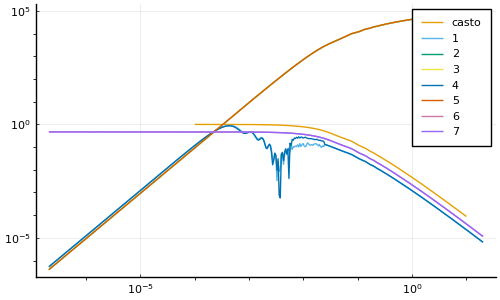

In [9]:
P = plot(ks_tf, abs.(pks_tf), axis=:log, label="casto", size=(500, 300))
for (i, ys) in enumerate(pks_all_tf)
    plot!(P, ks_all_tf, abs.(ys), label="$i")
end
P

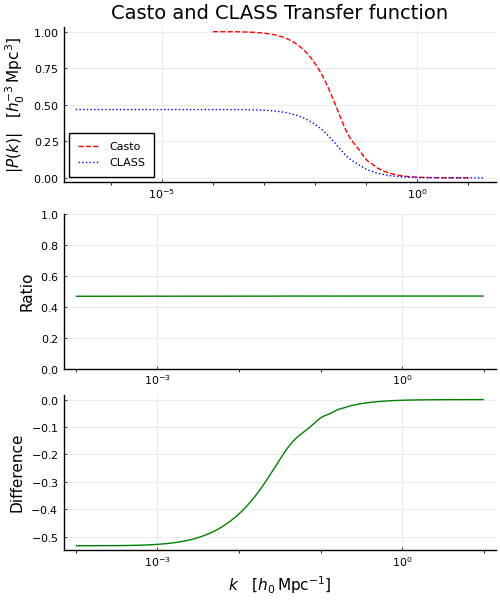

In [10]:
xs_1 = ks_tf
ys_1 = abs.(pks_tf)

xs_2 = ks_all_tf
ys_2 =  abs.(pks_all_tf[7]) 
spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "Casto and CLASS Transfer function",
    label=["Casto" "CLASS"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0,1), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
p3 = plot(xs_1, spline.(xs_1) .- ys_1, 
    ylabel="Difference", lc=:green, 
    xaxis=:log,
    #ylim=(0.0,1), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#display(P)

## Code my Transfer Function

In [11]:
struct my_TF
    left_value::Float64
    left::Float64
    
    spline::Dierckx.Spline1D

    r_si::Float64
    r_b::Float64
    r_a::Float64
    right::Float64
    
    
    function my_TF(ks, Tks)
        left_val = sum(Tks[1:10])/10
        r_si, r_b, r_a = GaPSE.power_law_from_data(
            ks, Tks, [-2.0, 1.0], ks[end-15] , ks[end]; con = false)
        spline = Spline1D(ks, Tks; bc = "error")
        
        new(left_val, ks[2], spline, r_si, r_b, r_a, ks[end])
    end
    
end;


function (TF::my_TF)(k)
     if k < TF.left
          return TF.left_value
     elseif k > TF.right
          return GaPSE.power_law(k, TF.r_si, TF.r_b, TF.r_a)
     else
          return TF.spline(k)
     end
end;

In [12]:
TF_casto = my_TF(ks_tf, pks_tf);

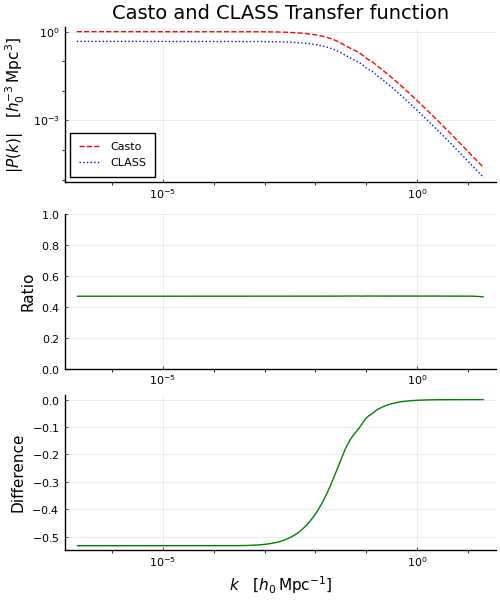

In [13]:
xs_1 = ks_all_tf
ys_1 = abs.(TF_casto.(xs_1))

xs_2 = ks_all_tf
ys_2 =  abs.(pks_all_tf[7]) 
spline = Spline1D(xs_2, ys_2)


S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "Casto and CLASS Transfer function",
    label=["Casto" "CLASS"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.0,1), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
p3 = plot(xs_1, spline.(xs_1) .- ys_1, 
    ylabel="Difference", lc=:green, 
    xaxis=:log,
    #ylim=(0.0,1), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#display(P)

## Code f_NL_integrals

In [14]:
struct f_NL_IntegralIPS
    l_si::Float64
    l_b::Float64
    l_a::Float64
    left::Float64

    spline::Dierckx.Spline1D

    r_si::Float64
    r_b::Float64
    r_a::Float64
    right::Float64

    function f_NL_IntegralIPS(cosmo::GaPSE.Cosmology, l, n; 
            z = nothing,bf::Float64 = 1.0,
            N::Int = 1024, kmin = 1e-4, kmax = 1e3, s0 = 1e-3, 
            fit_left_min = nothing, fit_left_max = nothing, p0_left = nothing, con = false,
            fit_right_min = nothing, fit_right_max = nothing, p0_right = nothing)


        rs, xis = xicalc(k -> cosmo.IPS(k) * α_bias(k, bf, cosmo; z = z), l, n; 
            N = N, kmin = kmin, kmax = kmax, r0 = s0)

        fit_left_MIN = isnothing(fit_left_min) ? rs[2] : fit_left_min
        fit_left_MAX = isnothing(fit_left_max) ? rs[16] : fit_left_max
        p_0_left = isnothing(p0_left) ? (con == true ? [-1.0, 1.0, 0.0] : [-1.0, 1.0]) : p0_left
        l_si, l_b, l_a = GaPSE.power_law_from_data(
           rs, xis, p_0_left, fit_left_MIN, fit_left_MAX; con = con)

        fit_right_MIN = isnothing(fit_right_min) ? rs[length(rs)-16] : fit_right_min
        fit_right_MAX = isnothing(fit_right_max) ? rs[length(rs)-1] : fit_right_max
        p_0_right = isnothing(p0_right) ? [-4.0, 1.0] : p0_right
        r_si, r_b, r_a = GaPSE.power_law_from_data(
           rs, xis, p_0_right, fit_right_MIN, fit_right_MAX; con = false)

        ind_left = findfirst(x -> x > fit_left_MIN, rs) - 1
        ind_right = findfirst(x -> x >= fit_right_MAX, rs)
        new_rs = vcat(rs[ind_left:ind_right])
        new_Is = vcat(xis[ind_left:ind_right])
        spline = Spline1D(new_rs, new_Is; bc = "error")

        #println("\nleft = $l_si , $l_b , $l_a, $fit_left_min")
        #println("right = $r_si , $r_b , $r_a, $fit_right_MAX\n")

        new(l_si, l_b, l_a, fit_left_MIN, spline, r_si, r_b, r_a, fit_right_MAX)
    end
end;


function (Iln::f_NL_IntegralIPS)(x)
     if x < Iln.left
          return GaPSE.power_law(x, Iln.l_si, Iln.l_b, Iln.l_a)
     elseif x > Iln.right
          #warning("i am going too right! ")
          return GaPSE.power_law(x, Iln.r_si, Iln.r_b, Iln.r_a)
     else
          return Iln.spline(x)
     end
end;

## Reading Casto I00 and I20

In [15]:
casto_ss, casto_Is = GaPSE.readxall("../data/I_alpha.dat");
casto_I00s, casto_I20s = casto_Is[1], casto_Is[2];

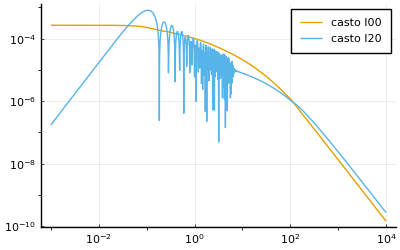

In [53]:
plot(casto_ss, casto_I00s, axis=:log, size=(400, 250), label = "casto I00")
plot!(casto_ss, abs.(casto_I20s), label = "casto I20")

## α_bias

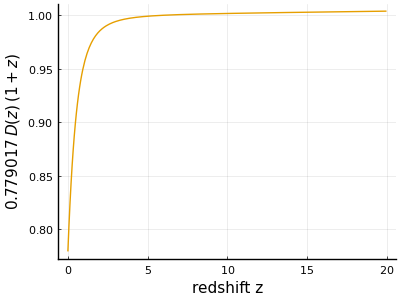

In [16]:
zs = range(0, 20, length=300)
plot(zs, [0.779017*cosmo.D_of_s(cosmo.s_of_z(z)) * (1+z) for z in zs],
    label=false, size=(400, 300), ylabel=L"0.779017 \,  D(z) \, (1+z)", xlabel="redshift z")

In [17]:
function α_bias(k, bf, cosmo::GaPSE.Cosmology; z=nothing)
     D = cosmo.D_of_s(isnothing(z) ? cosmo.s_eff : z)
     Ω_M0 = cosmo.params.Ω_M0 #1.68647
     return 3.0/2.0 * bf *  Ω_M0 * (100 / 299792.458)^2 / (0.779017 * D * k^2 * TF_casto(k))
end;

In [41]:
α_bias(1,1,cosmo; z=0)

1.394243095647545e-5

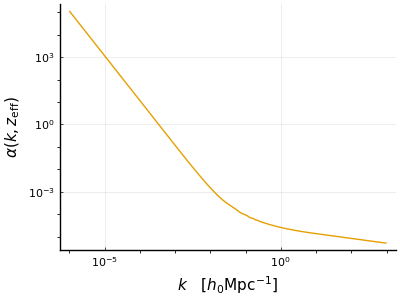

In [19]:
ks = 10 .^ range(-6, 3, length=300)
plot(ks, [α_bias(k, 1, cosmo) for k in ks], axis=:log,
    label=false, size=(400, 300), ylabel=L"\alpha(k,z_{\rm eff})", 
    xlabel=L"k \quad [h_0 \mathrm{Mpc^{-1}}]")

## S monopole and dipole

In [70]:
I00 = f_NL_IntegralIPS(cosmo, 0, 0; kmin = 1e-8, kmax = 1e4, z = 0,
    fit_left_min = 5e-2, fit_left_max = 1e-1, con=false);
I20 = f_NL_IntegralIPS(cosmo, 2, 0; kmin = 1e-8, kmax = 1e4, z = 0, 
    fit_left_min = 5e-1, fit_left_max = 1e0, con=false);

In [71]:
ss = 10 .^ range(-3,4; length=300);
I00s = [I00(s) for s in ss]
I20s = [I20(s) for s in ss]
orig_I00s = [cosmo.tools.I02(s) * s^2 for s in ss]; 

In [72]:
3/2*cosmo.params.Ω_M0/0.779017/cosmo.D_of_s(0), 0.779017^2

(0.5774970250970135, 0.6068674862889999)

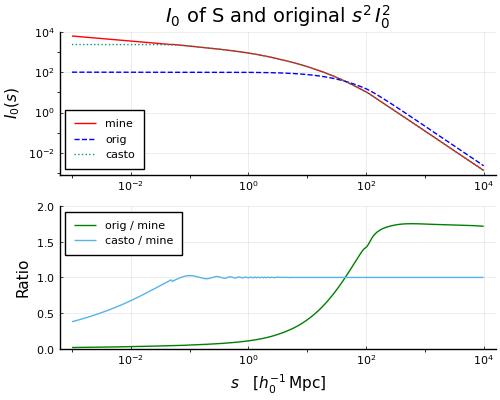

In [82]:
xs_1 = ss
ys_1 = I00s ./ (100 / 299792.458) .^2

xs_2 = ss
ys_2 = [abs(cosmo.tools.I02(s)) * s^2 for s in ss] 
spline_2 = Spline1D(xs_2, ys_2)

xs_3 = casto_ss
ys_3 = casto_I00s ./ (100 / 299792.458) .^2
spline_3 = Spline1D(xs_3, ys_3)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"I_0"*" of S and original " * L"s^2 \, I_0^2",
    label=["mine" "orig"], ls=[:solid :dash], 
    ylabel = L"I_0(s)",
    legend=:bottomleft)
plot!(p1, xs_3, ys_3, label="casto", ls=:dot)

p2 = plot(xs_1, spline_2.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, label = "orig / mine",
    ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
plot!(p2, xs_1, spline_3.(xs_1) ./ ys_1, label = "casto / mine")
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )

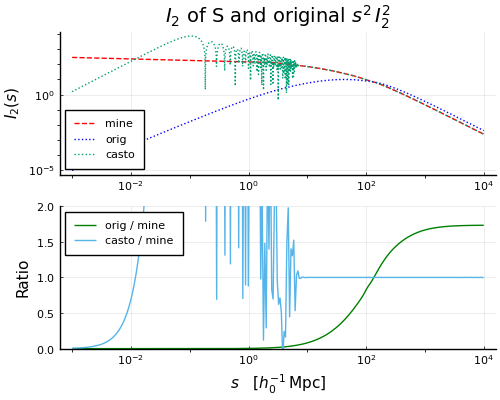

In [80]:
xs_1 = ss
ys_1 = I20s ./ (100 / 299792.458) .^2  #.* 1e13

xs_2 = ss
ys_2 = [abs(cosmo.tools.I22(s)) * s^2 for s in ss] 
spline_2 = Spline1D(xs_2, ys_2)

xs_3 = casto_ss
ys_3 = abs.(casto_I20s) ./ (100 / 299792.458) .^2
spline_3 = Spline1D(xs_3, ys_3)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"I_2"*" of S and original " * L"s^2 \, I_2^2",
    label=["mine" "orig"], ls=[:dash :dot], 
    ylabel = L"I_2(s)",
    legend=:bottomleft)
plot!(p1, xs_3, ys_3, label="casto", ls=:dot)

p2 = plot(xs_1, spline_2.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, label = "orig / mine",
    ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
plot!(p2, xs_1, spline_3.(xs_1) ./ ys_1, label = "casto / mine")
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )

## xi_S_multipole

In [25]:
function ξ_S_L0(P::GaPSE.Point, cosmo::GaPSE.Cosmology)
     b = cosmo.params.b
     s = P.comdist
     
     Peff = GaPSE.Point(cosmo.s_eff, cosmo)
     D, f = Peff.D, Peff.f

     2.0 * (b + f / 3.0) * D^2 * I00(s)
end

function ξ_S_L0(s1, cosmo::GaPSE.Cosmology)
     P1 = GaPSE.Point(s1, cosmo)
     return ξ_S_L0(P1, cosmo)
end

function ξ_S_L2(P::GaPSE.Point, cosmo::GaPSE.Cosmology)
     s = P.comdist

     Peff = GaPSE.Point(cosmo.s_eff, cosmo)
     D, f = Peff.D, Peff.f

     - 4.0 / 3.0 * f * D^2 * I20(s)
end

function ξ_S_L2(s1, cosmo::GaPSE.Cosmology)
     P1 = GaPSE.Point(s1, cosmo)
     return ξ_S_L2(P1, cosmo)
end

function ξ_S(s1, y, cosmo::GaPSE.Cosmology)
     return ξ_S_L0(s1, cosmo) + ξ_S_L2(s1, cosmo) * Pl(y, 2)
end;

In [26]:
function integrand_ξ_S_multipole(s, μ, cosmo::GaPSE.Cosmology;
     L::Int=0, use_windows::Bool=true)

     res = if use_windows == true
          ξ_S(s, μ, cosmo) .* (GaPSE.spline_integrF(s, μ, cosmo.windowFint) / cosmo.WFI_norm * Pl(μ, L))
     else
          ξ_S(s, μ, cosmo) .* Pl(μ, L)
     end

     return (2.0 * L + 1.0) / 2.0 * res
end

function ξ_S_multipole(
     s, cosmo::GaPSE.Cosmology;
     L::Int=0,
     use_windows::Bool=true,
     enhancer::Float64=1e6,
     μ_atol::Float64=0.0,
     μ_rtol::Float64=1e-2)

     orig_f(μ) = enhancer * integrand_ξ_S_multipole(s, μ, cosmo;
          L=L, use_windows=use_windows)

     int = quadgk(μ -> orig_f(μ), -1.0, 1.0; atol=μ_atol, rtol=μ_rtol)[1]

     return int / enhancer
end

function map_ξ_S_multipole(cosmo::GaPSE.Cosmology,
     v_ss=nothing;
     pr::Bool=true,
     N_log::Int=1000,
     L::Int=0,
     kwargs...)

     t1 = time()
     ss = isnothing(v_ss) ? 10 .^ range(0, 3, length=N_log) : v_ss
     xis = pr ? begin
          @showprogress "ξ_S, L=$L: " [
               ξ_S_multipole(s, cosmo; L=L, kwargs...) for s in ss
          ]
     end : [
          ξ_S_multipole(s, cosmo; L=L, kwargs...) for s in ss
     ]

     t2 = time()
     pr && println("\ntime needed for map_ξ_S_multipole " *
                   "[in s] = $(@sprintf("%.5f", t2-t1)) ")
     return (ss, xis)
end;

## Code TPCF and PS of S

In [27]:
ss_S_L0_withF, xis_S_L0_withF = map_ξ_S_multipole(cosmo, 
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=0, use_windows = true);
ks_S_L0_withF, pks_S_L0_withF = GaPSE.PS_multipole(ss_S_L0_withF, 
    xis_S_L0_withF; L = 0, ps_kwargs(tf)...);

ξ_S, L=0: 100%|█████████████████████████████████████████| Time: 0:00:02



time needed for map_ξ_S_multipole [in s] = 2.54686 

time needed for this Power Spectrum computation [in s] = 0.1922600269317627



In [28]:
ss_ppm_L0_withF, xis_ppm_L0_withF = GaPSE.map_ξ_PPMatter_multipole(cosmo, 
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);
ks_ppm_L0_withF, pks_ppm_L0_withF = GaPSE.PS_multipole(ss_ppm_L0_withF, 
    xis_ppm_L0_withF; L = 0, ps_kwargs(tf)...);

PP Matter, L=0: 100%|███████████████████████████████████| Time: 0:00:04



time needed for map_ξ_PPMatter_multipole [in s] = 4.64166 

time needed for this Power Spectrum computation [in s] = 0.0013229846954345703



## Code for reading TPCF and PS of Newtonian, GRsum and PPMatter

In [29]:
ss_LD_L0_withF, xis_sum_LD_L0_withF, all_xis_LD_L0_withF = 
    GaPSE.readxyall("Effective_fNL_z115_files/"*"map_sum_xis_LD_L0_withF.txt");
ss_GNC_L0_withF, xis_sum_GNC_L0_withF, all_xis_GNC_L0_withF = 
    GaPSE.readxyall("Effective_fNL_z115_files/"*"map_sum_xis_GNC_L0_withF.txt");
ss_GNCxLD_L0_withF, xis_sum_GNCxLD_L0_withF, all_xis_GNCxLD_L0_withF = 
    GaPSE.readxyall("Effective_fNL_z115_files/"*"map_sum_xis_GNCxLD_L0_withF.txt");
ss_LDxGNC_L0_withF, xis_sum_LDxGNC_L0_withF, all_xis_LDxGNC_L0_withF = 
    GaPSE.readxyall("Effective_fNL_z115_files/"*"map_sum_xis_LDxGNC_L0_withF.txt");

spline_LD_sum_L0_withF = Spline1D(ss_LD_L0_withF, xis_sum_LD_L0_withF; bc = "error");
spline_GNC_sum_L0_withF = Spline1D(ss_GNC_L0_withF, xis_sum_GNC_L0_withF; bc = "error");
spline_GNCxLD_sum_L0_withF = Spline1D(ss_GNCxLD_L0_withF, xis_sum_GNCxLD_L0_withF; bc = "error");
spline_LDxGNC_sum_L0_withF = Spline1D(ss_LDxGNC_L0_withF, xis_sum_LDxGNC_L0_withF; bc = "error");

In [30]:
GaPSE.print_all_PS_multipole("Effective_fNL_z115_files/"*"map_sum_xis_GNC_L0_withF.txt", 
    DIR*"map_sum_ps_GNC_L0_withF.txt", "GNC"; L=0, ps_kwargs(tf)...)
ks_all_GNC, pks_sum_GNC, pks_all_GNC = GaPSE.readxyall(DIR*"map_sum_ps_GNC_L0_withF.txt");


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/map_sum_xis_GNC_L0_withF.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.529897928237915



In [31]:
ss_GRsum_L0_withF = ss_GNC_L0_withF;
xis_GRsum_L0_withF = [spline_LD_sum_L0_withF(s) + spline_GNC_sum_L0_withF(s) + 
        spline_GNCxLD_sum_L0_withF(s) + spline_LDxGNC_sum_L0_withF(s)
        for s in ss_GRsum_L0_withF];

open(DIR*"xi_ALL_GR_TPCF_SUMMED_L0_withF.txt", "w") do io
    println(io, GaPSE.BRAND)
    println(io, "# This is the sum of all the GR effects TPCFs (with window):")
    println(io, "# LD (16), GNC (25), GNCxLD (20), LDxGNC (20)\n#")
    GaPSE.parameters_used(io, cosmo; logo=false)
    println(io, "# s [Mpc/h_0] \t xi_ALLSUMMED")
    for (s,xi) in zip(ss_GRsum_L0_withF, xis_GRsum_L0_withF)
        println(io, "$s \t $xi")
    end
end

GaPSE.print_PS_multipole(DIR*"xi_ALL_GR_TPCF_SUMMED_L0_withF.txt", 
    DIR*"ps_ALL_GR_TPCF_SUMMED_L0_withF.txt"; 
    L = 0,  ps_kwargs(tf)...);
ks_GRsum_L0_withF, pks_GRsum_L0_withF = GaPSE.readxy(DIR*"ps_ALL_GR_TPCF_SUMMED_L0_withF.txt");


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ALL_GR_TPCF_SUMMED_L0_withF.txt" 

time needed for this Power Spectrum computation [in s] = 0.0012438297271728516



In [32]:
ks_Newtonian_L0_withF, pks_Newtonian_L0_withF = GaPSE.PS_multipole(ss_GNC_L0_withF, 
    all_xis_GNC_L0_withF[1]; L = 0,  ps_kwargs(tf)...);


time needed for this Power Spectrum computation [in s] = 0.0032770633697509766



In [33]:
spline_ppm_L0_withF = Spline1D(ks_ppm_L0_withF, pks_ppm_L0_withF; bc = "error");
spline_GRsum_L0_withF = Spline1D(ks_GRsum_L0_withF, pks_GRsum_L0_withF; bc = "error");
spline_Newtonian_L0_withF = Spline1D(ks_Newtonian_L0_withF, pks_Newtonian_L0_withF; bc = "error");

In [34]:
ks = ks_GRsum_L0_withF
diff_Newt_ppm =  pks_Newtonian_L0_withF .- pks_ppm_L0_withF
diff_ppm_GRsum = pks_ppm_L0_withF - pks_GRsum_L0_withF
diff_Newt_GRsum = pks_Newtonian_L0_withF .- pks_GRsum_L0_withF;

## Check Plots

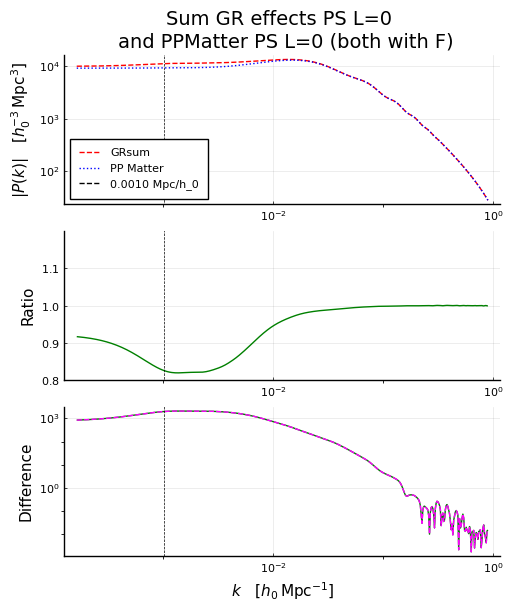

In [35]:
xs_1 = ks_GRsum_L0_withF
ys_1 = pks_GRsum_L0_withF

xs_2 = ks_ppm_L0_withF
ys_2 = pks_ppm_L0_withF
spline = Spline1D(xs_2, ys_2)


xs_3 = ks_GRsum_L0_withF
ys_3 = diff_ppm_GRsum

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "Sum GR effects PS L=0 \n and PPMatter PS L=0 (both with F)",
    label=["GRsum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_L0_GRsum-PPMatter_withF.pdf")
#display(P)

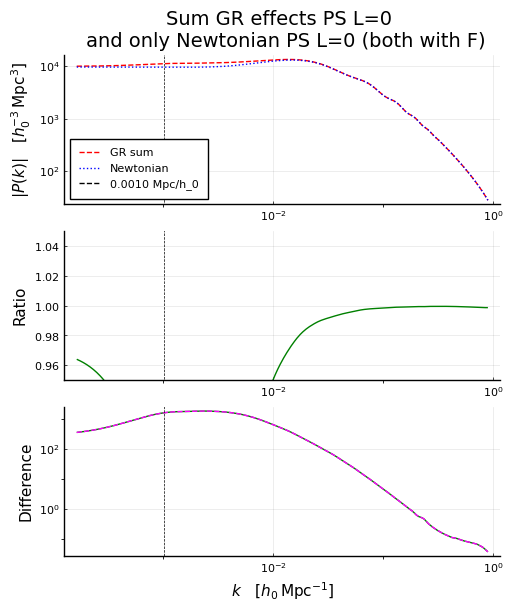

In [36]:
xs_1 = ks_GRsum_L0_withF
ys_1 = pks_GRsum_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)

xs_3 = ks_GRsum_L0_withF
ys_3 = diff_Newt_GRsum

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "Sum GR effects PS L=0 \n and only Newtonian PS L=0 (both with F)",
    label=["GR sum" "Newtonian"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.95,1.05), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log, 
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_L0_GRsum-Newton_withF.pdf")
#display(P)

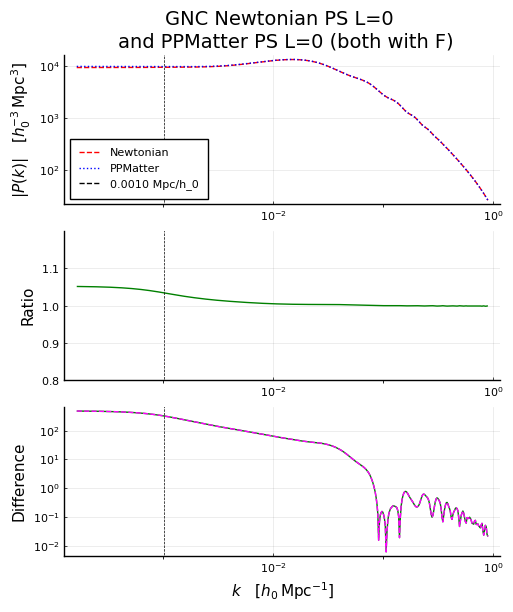

In [37]:
xs_1 = ks_ppm_L0_withF
ys_1 = pks_ppm_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)


xs_3 = ks_GRsum_L0_withF
ys_3 = diff_Newt_ppm

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "GNC Newtonian PS L=0 \n and PPMatter PS L=0 (both with F)",
    label=["Newtonian" "PPMatter"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_L0_Newton-PPMatter_withF.pdf")
#display(P)

## Plots

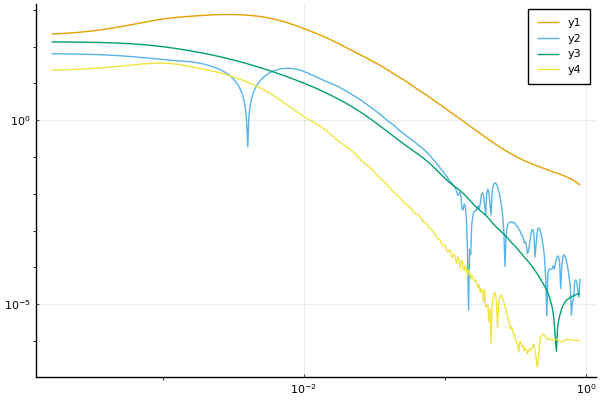

In [38]:
plot(ks, abs.(pks_all_GNC[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]]), axis=:log)
plot!(ks, abs.(pks_all_GNC[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]]))
#plot!(ks, abs.(pks_all_GNC[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]]))
plot!(ks, abs.(pks_all_GNC[GaPSE.INDEX_GR_EFFECT_GNC["newton_localgp"]]))
plot!(ks, abs.(pks_all_GNC[GaPSE.INDEX_GR_EFFECT_GNC["lensing_doppler"]]))

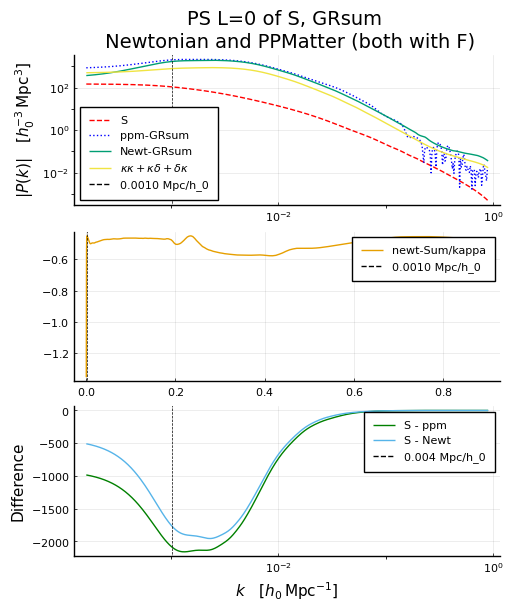

In [39]:
xs_1 = ks_S_L0_withF
ys_1 = pks_S_L0_withF


xs_4 = ks
ys_4 = pks_all_GNC[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+
        2.0 .* pks_all_GNC[GaPSE.INDEX_GR_EFFECT_GNC["newton_localgp"]]



xs_2 = ks
ys_2 = diff_ppm_GRsum

xs_3 = ks
ys_3 = diff_Newt_GRsum

spline_2 = Spline1D(xs_2, ys_2)
spline_3 = Spline1D(xs_3, ys_3)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS L=0 of S, GRsum \n Newtonian and PPMatter (both with F)",
    label=["S" "ppm-GRsum"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
plot!(p1, xs_3, abs.(ys_3), label="Newt-GRsum")
plot!(p1, xs_4, abs.(ys_4), label=L"\kappa\kappa + \kappa\delta + \delta\kappa")
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
#=
p2 = plot(xs_1, ys_1 ./ spline_2.(xs_1), 
    ylabel="Ratio", lc=:green, ylim = (-0.2, 0.2),
    xaxis=:log, label="ppm/S",
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, ys_1 ./ spline_3.(xs_1), label="Newt/S")
=#
p2 = plot(xs_4, ys_4 ./ spline_3.(xs_4), label="newt-Sum/kappa")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, spline_2.(xs_1) .- ys_1, 
    label="S - ppm", lc=:green, 
    xaxis=:log, ylabel="Difference",
    legend=true, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_1, spline_3.(xs_1) .- ys_1, label="S - Newt")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_S-GNCsum-Newt-PPmatter_L0_withF.pdf")
#display(P)

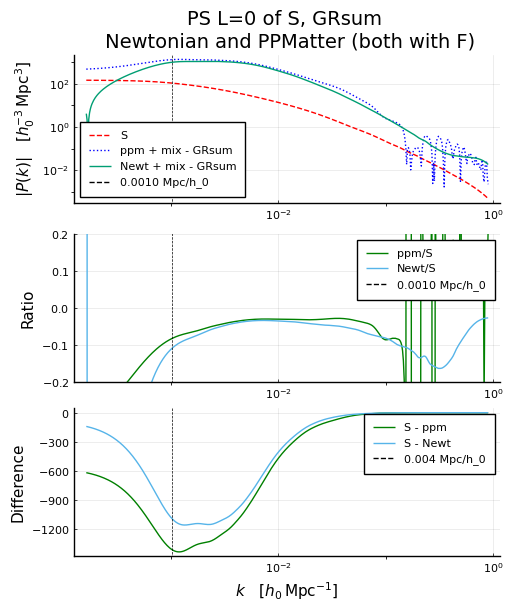

In [40]:
xs_1 = ks_S_L0_withF
ys_1 = pks_S_L0_withF


xs_4 = ks
ys_4 = pks_all_GNC[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+ 
    pks_all_GNC[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]] .+ 
    pks_all_GNC[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]]

xs_2 = ks
ys_2 = diff_ppm_GRsum .+ ys_4

xs_3 = ks
ys_3 = diff_Newt_GRsum .+ ys_4

spline_2 = Spline1D(xs_2, ys_2)
spline_3 = Spline1D(xs_3, ys_3)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.4f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS L=0 of S, GRsum \n Newtonian and PPMatter (both with F)",
    label=["S" "ppm + mix - GRsum"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
plot!(p1, xs_3, abs.(ys_3), label="Newt + mix - GRsum")
#plot!(p1, xs_4, abs.(ys_4), label=L"\kappa\kappa + \kappa\delta + \delta\kappa")
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, ys_1 ./ spline_2.(xs_1), 
    ylabel="Ratio", lc=:green, ylim = (-0.2, 0.2),
    xaxis=:log, label="ppm/S",
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, ys_1 ./ spline_3.(xs_1), label="Newt/S")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, spline_2.(xs_1) .- ys_1, 
    label="S - ppm", lc=:green, 
    xaxis=:log, ylabel="Difference",
    legend=true, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_1, spline_3.(xs_1) .- ys_1, label="S - Newt")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_S-GNCsum-Newt-PPmatter_L0_withF.pdf")
#display(P)